# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase


In [6]:
fine_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=1024, nx=2048)

In [7]:
fine_doubleJetCase_args, fine_doubleJetCase_init = fine_doubleJetCase.getInitConditions()
fine_doubleJetCase_args["dt"] = 0.0

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

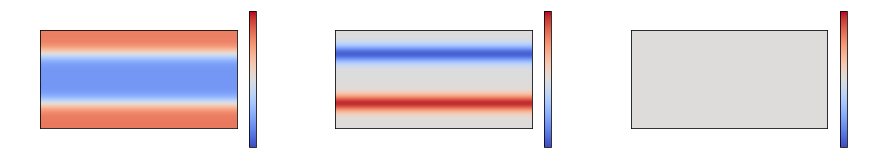

In [8]:
from utils.DoubleJetPlot import *
imshow3(list(fine_doubleJetCase_init.values()), eta_vlim=3.5, huv_vlim=750)

Prepare KL model error

In [9]:
fine_grid_args = {"nx" : fine_doubleJetCase_args["nx"],
             "ny" : fine_doubleJetCase_args["ny"],
             "dx" : fine_doubleJetCase_args["dx"],
             "dy" : fine_doubleJetCase_args["dy"],
             "gpu_ctx" : fine_doubleJetCase_args["gpu_ctx"],
             "gpu_stream": gpu_stream,
             "boundary_conditions" : fine_doubleJetCase_args["boundary_conditions"]
             }

start_basis = 1
num_bases = 7
sim_model_error_basis_args = {
                            "basis_x_start": start_basis+1, 
                            "basis_x_end": start_basis+1+num_bases,
                            "basis_y_start": start_basis,
                            "basis_y_end": start_basis+num_bases,

                            "kl_decay": 0.9,
                            "kl_scaling": 0.001,
                            }

sim_mekl = ModelErrorKL.ModelErrorKL(**fine_grid_args, **sim_model_error_basis_args)

In [10]:
sim_model_error_time_step = 60.0

Define DoubleJet sim

In [11]:
sim = CDKLM16.CDKLM16(**fine_doubleJetCase_args, **fine_doubleJetCase_init)
sim.model_error = sim_mekl
sim.model_time_step = sim_model_error_time_step

In [12]:
eta = Common.CUDAArray2D(sim.gpu_stream, sim.nx, sim.ny, 2, 2, np.zeros((sim.ny + 4, sim.nx + 4)))
hu  = Common.CUDAArray2D(sim.gpu_stream, sim.nx, sim.ny, 2, 2, np.zeros((sim.ny + 4, sim.nx + 4)))
hv  = Common.CUDAArray2D(sim.gpu_stream, sim.nx, sim.ny, 2, 2, np.zeros((sim.ny + 4, sim.nx + 4)))

In [13]:
sim.model_error.perturbOceanState(eta, hu, hv,
                               sim.bathymetry.Bi,
                               sim.dx, sim.dy,
                               sim.f, beta=sim.coriolis_beta, 
                               g=sim.g, 
                               y0_reference_cell=sim.y_zero_reference_cell,
                               update_random_field=True,
                               perturbation_scale=1.0,
                               land_mask_value=sim.bathymetry.mask_value,
                               stream=None)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

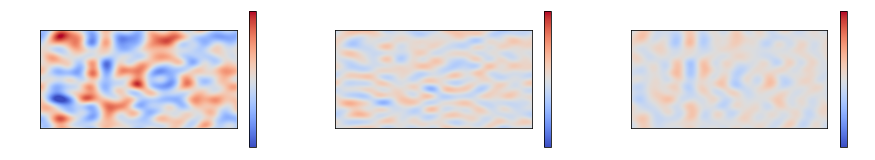

In [14]:
imshow3([eta.download(gpu_stream=sim.gpu_stream), hu.download(gpu_stream=sim.gpu_stream), hv.download(gpu_stream=sim.gpu_stream)], eta_vlim=0.002, huv_vlim=2)